In [1]:
import struct
from typing import List

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# Reading Data

In [2]:
def load_images(path: str):
    # Images in 784x1 format
    images = []
    
    with open(path, mode='rb') as f:
        # Read header values
        magic_number, n, rows, cols = struct.unpack('>IIII', f.read(16))
        
        for _ in range(n):
            # Read and unpack image (which has 28x28 bytes)
            image = list(struct.unpack('>' + 'B' * (rows * cols), f.read(rows * cols)))
            images.append(image)
    
    return np.array(images)

In [3]:
def load_labels(path: str):
    with open(path, mode='rb') as f:
        # Read header values
        magic_number, n = struct.unpack('>II', f.read(8))
        
        # Read and return labels
        return np.array(struct.unpack('>' + 'B' * n, f.read(n)))

In [4]:
train_images_path = "train-images.idx3-ubyte"
train_labels_path = "train-labels.idx1-ubyte"
test_images_path = "t10k-images.idx3-ubyte"
test_labels_path = "t10k-labels.idx1-ubyte"

train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)

## Whitening (Z-Scoring) data

In [5]:
def z_score(data):
    mean = np.mean(data)
    std = np.std(data)
    return mean, std, (data - mean) / std

In [6]:
mean, std, train_images = z_score(train_images)

In [7]:
test_images = (test_images - mean) / std

# Re-shape and Visualization

In [8]:
def reshape_matrix_to_images(matrix_images):
    apply_function = lambda row: row.reshape((28, 28))
    return np.apply_along_axis(apply_function, axis=1, arr=matrix_images)

In [216]:
def plot_image(reshaped_image):
    plt.imshow(reshaped_image, cmap=plt.get_cmap('gray'))
    plt.show()

## Checking image-label pair

### Train Data

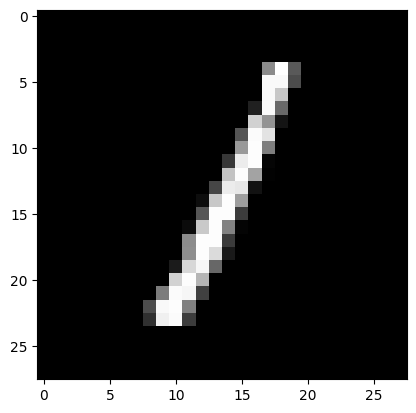

Random Index:  27020
Label: 1


In [11]:
reshaped_images = reshape_matrix_to_images(train_images)
rand_index = np.random.randint(0, len(train_images))
plot_image(reshaped_images[rand_index])
print("Random Index: ", rand_index)
print("Label:", train_labels[rand_index])

### Test data

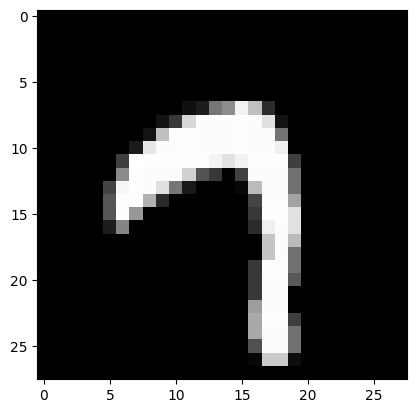

Label: 7


In [12]:
reshaped_images = reshape_matrix_to_images(test_images)
rand_index = np.random.randint(0, len(test_images))
plot_image(reshaped_images[rand_index])
print("Label:", test_labels[rand_index])

In [13]:
def one_hot_encoding(labels):
    one_hot_encoded_labels = []
    for i, label in enumerate(labels):
        one_hot_label = np.zeros(10)
        one_hot_label[label] = 1.0
        one_hot_encoded_labels.append(one_hot_label)
    
    return np.array(one_hot_encoded_labels)

In [14]:
train_encoded_labels = one_hot_encoding(train_labels)
test_encoded_labels = one_hot_encoding(test_labels)

## Checking 'one_hot_encoding' function working correct

In [15]:
train_encoded_labels[10]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [16]:
train_labels[10]

np.int64(3)

# NN

## Activation Functions

In [17]:
from abc import ABC, abstractmethod


class ActivationFunction(ABC):
    @abstractmethod
    def forward(self, x):
        pass
    
    @abstractmethod
    def derivatives(self, x):
        pass

class Relu(ActivationFunction):
    def forward(self, x):
        return np.maximum(x, 0)
    
    def derivatives(self, x):
        return x > 0

class Softmax(ActivationFunction):
    def forward(self, x):
        exps = np.exp(x - x.max())
        return exps / np.sum(exps)
    
    def derivatives(self, x):
        return 1

## Weight Initializers

In [239]:
class WeightInitializer(ABC):
    @abstractmethod
    def init(self, n_in, n_out):
        pass
    
class NormalInitializer(WeightInitializer):
    def init(self, n_in, n_out):
        return np.random.standard_normal(size=(n_in, n_out))
    
class XavierInitializer(WeightInitializer):
    def init(self, n_in, n_out):
        return np.random.normal(0, 1/n_in, size=(n_in, n_out))

# Weights initializer from given research paper and yes, it works SUPER
class PaperInitializer(WeightInitializer):
    def init(self, n_in, n_out):
        return np.random.normal(0, np.sqrt(2/n_in), size=(n_in, n_out))

In [19]:
class Layer:
    def __init__(self, n_in, n_out, is_output = False,
                 weight_init: WeightInitializer = PaperInitializer(),
                 activation: ActivationFunction = Relu()):
        self.n_in = n_in
        self.n_out = n_out
        self.is_output = is_output
        
        self.weight_init = weight_init
        self.activation = activation
        
        self.weights = self.weight_init.init(n_in, n_out)
        self.bias = np.zeros((1, n_out))
        
        self.A_prev = None
        self.Z = None
        self.A_current = None
        
        self.Z_mean = None
        self.Z_std = None
        
        self.v = 0
    
    def forward(self, A_prev, is_training = True):
        self.A_prev = A_prev
        
        self.Z = np.dot(A_prev, self.weights) + self.bias
        
        
        if is_training and self.Z.shape[0] != 1:
            self.Z_mean = np.mean(self.Z, axis = 0)
            self.Z_std = np.std(self.Z, axis = 0)

        if self.Z_mean is not None and self.Z_std is not None:    
            self.Z = (self.Z - self.Z_mean) / self.Z_std
        
        self.A_current = self.activation.forward(self.Z)
        
        return self.A_current

    def backprop(self, dZ_prev, m, batch_mode):
        if batch_mode:
            self.A_prev = np.mean(self.A_prev, axis = 0, keepdims = True)
            self.Z = np.mean(self.Z, axis = 0, keepdims = True)
            self.A_current = np.mean(self.A_current, axis = 0, keepdims = True)
        
        if self.is_output:
            dZ = dZ_prev
        else:
            dZ = dZ_prev * self.activation.derivatives(self.Z)
        
        dW = 1/m * np.dot(self.A_prev.T, dZ)
        db = 1/m * np.sum(dZ, axis=0, keepdims=True)
        dZ_next = np.dot(dZ, self.weights.T)
        
        return dZ_next, dW, db
    
    def update(self, dW, db, learning_rate, beta):
        self.v = beta * self.v + (1 - beta) * dW
        
        self.weights -= learning_rate * self.v
        self.bias -= learning_rate * db

In [277]:
class NN:
    def __init__(self, layers: List[Layer], learning_rate: float = 0.1, beta=0.9, batch_size: int = 100):
        self.layers = layers
        self.layers[-1].is_output = True
        
        self.learning_rate = learning_rate
        self.beta = beta
        
        self.batch_size = batch_size
    
    def forward(self, X, is_training = True):
        if len(X.shape) == 1:
            A_prev = X.reshape((1, X.shape[0]))
        else:
            A_prev = X
            
        for layer in self.layers:
            A_prev = layer.forward(A_prev, is_training)
        
        return A_prev
    
    def backprop(self, y_pred, y_true, batch_mode):
        if batch_mode:
            dZ = np.mean((y_pred - y_true), axis = 0)
        else:
            dZ = y_pred - y_true
        
        if len(dZ.shape) == 1:
            dZ = dZ.reshape((1, dZ.shape[0]))
            
        for layer in self.layers[::-1]:
            dZ, dW, db = layer.backprop(dZ, y_true.shape[0], batch_mode)
            layer.update(dW, db, self.learning_rate, self.beta)
    
    def compute_loss(self, y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred))
    
    def accuracy(self, y_pred, y_true, batch_mode):
        if batch_mode:
            y_pred_max = np.argmax(y_pred, axis = 0)
            y_true_max = np.argmax(y_true, axis = 0)
            return np.sum(np.round(y_pred_max) == y_true_max) / y_true.shape[0]
        
        return np.sum(np.round(y_pred) == y_true) / y_true.shape[0]
    
    def train(self, train_set, train_label_set, test_set, test_label_set, batch_mode = False, epochs = 1000, decay_step = 10, decay_rate = 0.96):
        train_losses = []
        test_losses = []
        
        train_accuracies = []
        test_accuracies = []
        
        avg_train_loss = 0
        avg_test_loss = 0
        
        batch_count_train = train_set.shape[0] // self.batch_size
        batch_count_test = test_set.shape[0] // self.batch_size
        
        for epoch in tqdm(range(epochs + 1)):
            if batch_mode:
                rand_idx = np.random.randint(0, batch_count_train)
                start = rand_idx * self.batch_size
                end = (rand_idx + 1) * self.batch_size
                
                X = train_set[start:end]
                y = train_label_set[start:end]
            else:
                rand_idx = np.random.randint(0, train_set.shape[0])
                X = train_set[rand_idx]
                y = train_label_set[rand_idx]
            
            y_pred = self.forward(X)
            
            training_loss = self.compute_loss(y_pred, y)
            avg_train_loss += training_loss
            
            self.backprop(y_pred, y, batch_mode)
            
            acc = self.accuracy(y_pred, y, batch_mode)
            train_accuracies.append(acc)
            
            if batch_mode:
                rand_idx = np.random.randint(0, batch_count_test)
                start = rand_idx * self.batch_size
                end = (rand_idx + 1) * self.batch_size
                X_test = test_set[start:end]
                y_test = test_label_set[start:end]
            else:
                rand_idx = np.random.randint(0, train_set.shape[0])
                X_test = test_set[rand_idx]
                y_test = test_label_set[rand_idx]
            
            test_y_pred = self.forward(X_test, is_training = False)
            test_loss = self.compute_loss(test_y_pred, y_test)
            test_acc = self.accuracy(test_y_pred, y_test, batch_mode)
            avg_test_loss += test_loss
            test_accuracies.append(test_acc)
            
            if epoch % decay_step == 0 and epoch > 0:
                self.learning_rate *= decay_rate
                
                avg_train_loss /= decay_step
                avg_test_loss /= decay_step
                
                test_losses.append(avg_test_loss)
                train_losses.append(avg_train_loss)
                
                print(f"Loss (train) {epoch }: {avg_train_loss}")
                print(f"Loss (test) {epoch}: {avg_test_loss}")
                print(f"Accuracy (train) {epoch}: {np.mean(train_accuracies)}")
                print(f"Accuracy (test) {epoch}: {np.mean(test_accuracies)}")
                
                avg_train_loss = 0
                avg_test_loss = 0
    
        return train_losses, test_losses

# Experiment

## Splitting data into Training and Validation sets

In [278]:
perm = np.random.permutation(train_images.shape[0])
train_portion = 0.75

train_set = train_images[perm[:int(train_portion * train_images.shape[0])]]
train_label_set = train_encoded_labels[perm[:int(train_portion * train_labels.shape[0])]]

validation_set = train_images[perm[int(train_portion * test_images.shape[0]):]]
validation_label_set = train_encoded_labels[perm[int(train_portion * test_labels.shape[0]):]]

## Initialization of NN with distinct params

In [279]:
epochs = 10000
decay_step = epochs // 100

learning_rate = 0.1
beta = 0.9

batch_mode = False
batch_size = 10

nn = NN(layers=[
    Layer(784, 512),
    Layer(512, 10, activation=Softmax()),
], learning_rate=learning_rate, beta=beta, batch_size=batch_size)

## Training

In [280]:
train_losses, test_losses = nn.train(train_set, train_label_set, validation_set, validation_label_set, 
                                     epochs=epochs, decay_step=decay_step, batch_mode=batch_mode)

  0%|          | 0/10001 [00:00<?, ?it/s]

Loss (train) 100: 2.8920079524444926
Loss (test) 100: 2.553087882221654
Accuracy (train) 100: 0.8960396039603963
Accuracy (test) 100: 0.8960396039603962
Loss (train) 200: 1.4031884827544192
Loss (test) 200: 0.9473000154179648
Accuracy (train) 200: 0.9099502487562191
Accuracy (test) 200: 0.9134328358208955
Loss (train) 300: 0.8267386004303401
Loss (test) 300: 0.8824709430474654
Accuracy (train) 300: 0.9235880398671097
Accuracy (test) 300: 0.9239202657807309
Loss (train) 400: 0.6469537120673233
Loss (test) 400: 0.6699704604043316
Accuracy (train) 400: 0.9329177057356609
Accuracy (test) 400: 0.9329177057356609
Loss (train) 500: 0.5082456844009348
Loss (test) 500: 0.6619256514750629
Accuracy (train) 500: 0.9403193612774452
Accuracy (test) 500: 0.9391217564870261
Loss (train) 600: 0.5206772236749768
Loss (test) 600: 0.591465426576463
Accuracy (train) 600: 0.9447587354409317
Accuracy (test) 600: 0.9427620632279534
Loss (train) 700: 0.4078558730917932
Loss (test) 700: 0.5889980645738452
Accur

## Plotting Training and Validation losses

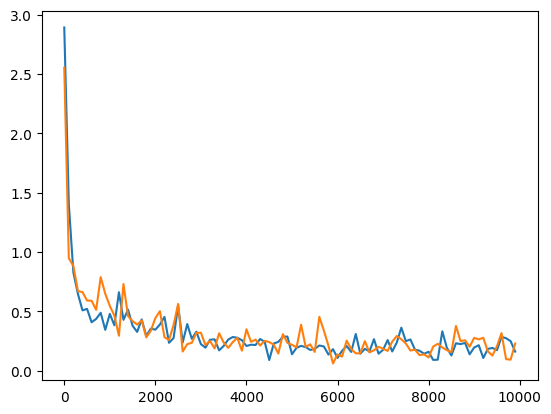

In [281]:
plt.plot(range(0, epochs, decay_step), train_losses, label='train')
plt.plot(range(0, epochs, decay_step), test_losses, label='test')
plt.show()

## Testing NN on Test set

In [282]:
output = nn.forward(test_images, is_training = False)

Predicted label: 5
True label: 5


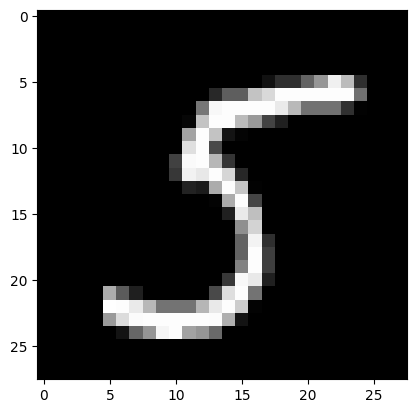

In [283]:
rand_idx = np.random.randint(0, test_images.shape[0])
predicted_label = np.argmax(nn.forward(test_images[rand_idx], is_training = False))
true_label = test_labels[rand_idx]
print(f"Predicted label: {predicted_label}")
print(f"True label: {true_label}")
plot_image(reshaped_images[rand_idx])

## Plotting weights from first layer (just for fun and maybe see some insights)

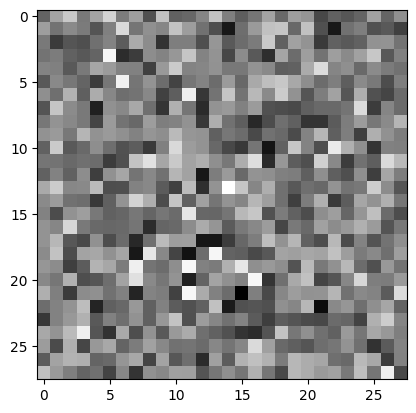

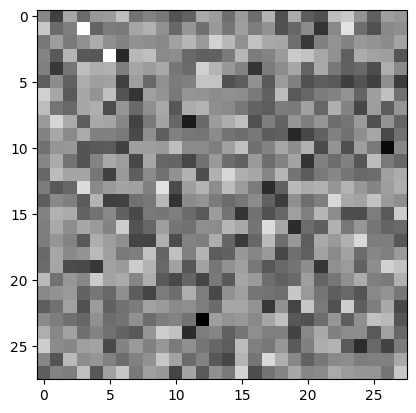

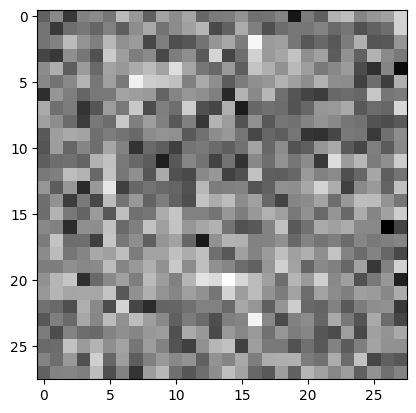

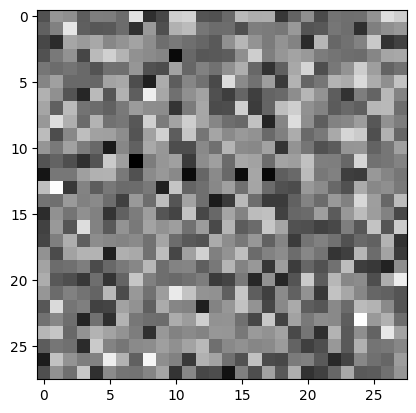

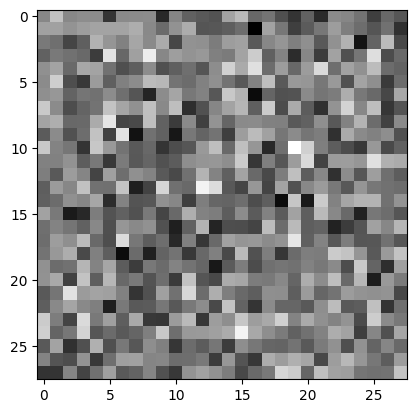

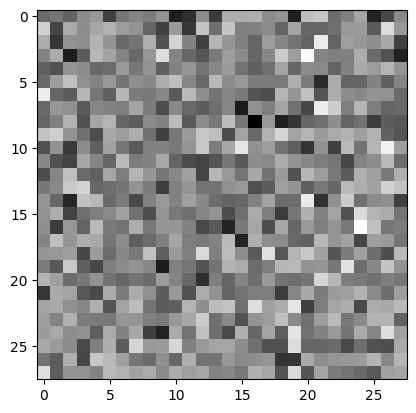

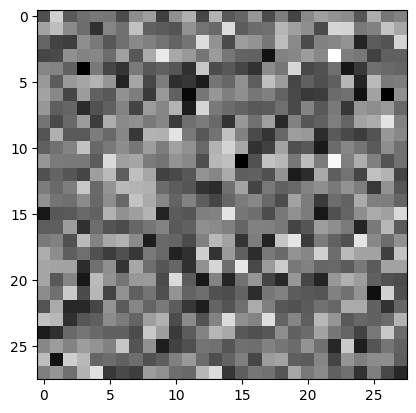

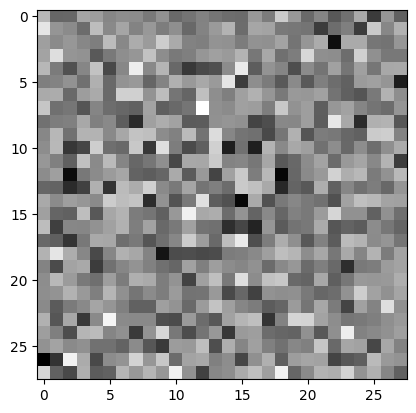

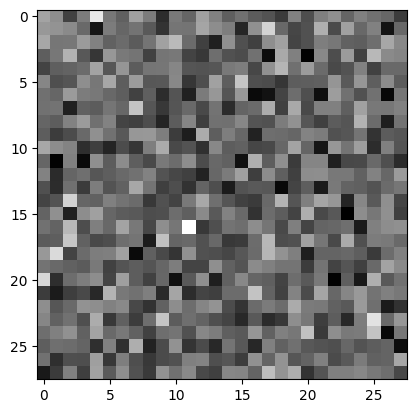

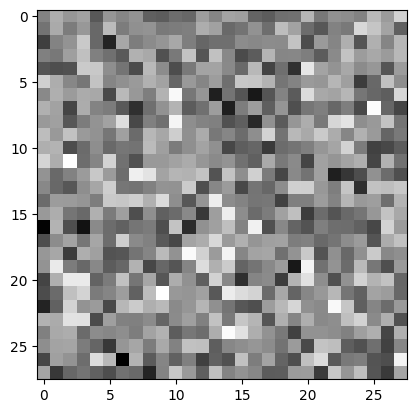

In [284]:
for i in range(10):
    plot_image(nn.layers[0].weights[:,i + 500].reshape((28, 28)))